In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install lightgbm

In [ ]:
import lightgbm as lgb
import pandas as pd
import numpy as np
from datetime import datetime as dt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error,r2_score,mean_squared_error
import json
from dateutil.relativedelta import relativedelta
from sklearn.model_selection import KFold

%matplotlib inline
pd.set_option('max_columns', 500)


PATH = './drive/MyDrive/Colab Notebooks/Lina/'

In [ ]:
def ti():
    print(dt.now().replace(microsecond=0))
       
def get_zaic(df,*args):
    ti()
    if not(isinstance(df,pd.DataFrame) or isinstance(df,pd.Series)):
        print('Не могу вернуть размер для объекта с типом',type(df))
    elif isinstance(df,pd.Series) or isinstance(df,pd.DataFrame) and df.shape[1] == 1:
        print(round(df.memory_usage(deep=True)/1024**2,2),'Mb')
    else:
        print(round(df.memory_usage(deep=True).sum()/1024**2,2),'Mb')
    print(df.shape)

def MAPE(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape

def calc_metrics(y_train, pred_train, y_test, pred_test, model_type):
    with open(PATH + 'model_logs.json', 'r') as fp:
            logs = json.load(fp)
    logs[model_type] = dict()

    print('TRAIN:')
    r2 = np.round(r2_score(y_train, pred_train), 3)
    print("R^2 : ", r2)
    mae = np.round(mean_absolute_error(y_train, pred_train), 3)
    print("MAE :", mae)
    rmse = np.round(np.sqrt(mean_squared_error(y_train, pred_train)), 3)
    print("RMSE:", rmse)
    mape = np.round(np.sqrt(MAPE(y_train, pred_train)), 3)
    print("MAPE:", mape)
    train_list = [r2, mae, rmse, mape]
    logs[model_type]['TRAIN'] = train_list
    
    print()

    print('TEST:')
    r2 = np.round(r2_score(y_test, pred_test), 3)
    print("R^2 : ", r2)
    mae = np.round(mean_absolute_error(y_test, pred_test), 3)
    print("MAE :", mae)
    rmse = np.round(np.sqrt(mean_squared_error(y_test, pred_test)), 3)
    print("RMSE:", rmse)
    mape = np.round(np.sqrt(MAPE(y_test, pred_test)), 3)
    print("MAPE:", mape)
    test_list = [r2, mae, rmse, mape]
    logs[model_type]['TEST'] = test_list

    with open(PATH + 'model_logs.json', 'w') as fp:
        json.dump(logs, fp)

## Загрузим данные 

In [ ]:
df_price = pd.read_csv(PATH + 'df_price.csv')
df_price.month = df_price.month.apply(pd.to_datetime)
df_price.drop(columns=['Unnamed: 0'], inplace = True)
get_zaic(df_price)
df_price.head(3)

2022-05-21 10:57:31
98.8 Mb
(166027, 78)


,apartment_ratio,unique_active_buildings_count,avg_price_sqm,month,unique_active_building_series_count,rooms_offered_3_ratio,city_quadkey,median_price_sqm,rooms_offered_4_more_ratio,rooms_offered_1_ratio,total_area_avg,studio_ratio,offer_count,rooms_offered_2_ratio,beauty_cnt,shopping_cnt,flats_count,cafe_restaurant_eating_out_cnt,entertainment_cnt,sport_cnt,chain_cnt,groceries_and_everyday_items_cnt,art_cnt,healthcare_cnt,expect_demolition,ceiling_height,laundry_and_repair_services_cnt,building_type_ANOTHER,building_type_BLOCK,building_type_BRICK,building_type_MONOLIT,building_type_PANEL,building_type_UNKNOWN,beauty_cnt_bmax,shopping_cnt_bmax,flats_count_bmax,cafe_restaurant_eating_out_cnt_bmax,entertainment_cnt_bmax,sport_cnt_bmax,chain_cnt_bmax,groceries_and_everyday_items_cnt_bmax,art_cnt_bmax,healthcare_cnt_bmax,expect_demolition_bmax,ceiling_height_bmax,laundry_and_repair_services_cnt_bmax,building_type_ANOTHER_bmax,building_type_BLOCK_bmax,building_type_BRICK_bmax,building_type_MONOLIT_bmax,building_type_PANEL_bmax,building_type_UNKNOWN_bmax,beauty_cnt_bmin,shopping_cnt_bmin,flats_count_bmin,cafe_restaurant_eating_out_cnt_bmin,entertainment_cnt_bmin,sport_cnt_bmin,chain_cnt_bmin,groceries_and_everyday_items_cnt_bmin,art_cnt_bmin,healthcare_cnt_bmin,expect_demolition_bmin,ceiling_height_bmin,laundry_and_repair_services_cnt_bmin,building_type_ANOTHER_bmin,building_type_BLOCK_bmin,building_type_BRICK_bmin,building_type_MONOLIT_bmin,building_type_PANEL_bmin,building_type_UNKNOWN_bmin,month_num,quarter,prehol_cnt,hol_cnt,q,m,s
0,0.0,1,22727.273438,2018-02-01,1,0.0,120132230303223,22727.273438,0.0,0.0,44.0,0.0,1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0,0.0,1.0,0,0,0,0,1,0,0.0,0.0,0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0,0.0,1.0,0,0,0,0,1,0,2,1,1,9,1,2,1
1,0.0,1,22727.273438,2018-03-01,1,0.0,120132230303223,22727.273438,0.0,0.0,44.0,0.0,1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0,0.0,1.0,0,0,0,0,1,0,0.0,0.0,0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0,0.0,1.0,0,0,0,0,1,0,3,1,1,11,1,3,2
2,0.0,1,43478.261719,2018-06-01,1,0.0,120132230332230,43478.261719,0.0,1.0,34.5,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0.0,0.0,0.0,1.0,0.0,3.0,0.0,0,0.0,0.0,0,0,0,0,1,0,0.0,0.0,0,0.0,0.0,0.0,1.0,0.0,3.0,0.0,0,0.0,0.0,0,0,0,0,1,0,6,2,1,10,2,6,3


## Разбивка на train / test 
Запускаем по походу постепенного добавления фичей, логируя метрики в файле.

Каждая итерация состоит из 2х частей - меняем SPLIT_TIPE и DESCRIBE

In [ ]:
target = 'avg_price_sqm'
SPLIT_TIPE = 'OOT'
DESCRIBE = 'Baseline_' + 'housebase_' + 'TimeFeat_' # + 'Lags_'
# target = 'avg_price_sqm_next'
model_cols = [x for x in df_price.columns if x not in [target, 'month']]

if SPLIT_TIPE == 'OOS':
    df_model = df_price[model_cols + [target]].copy()
else:
    df_model = df_price[model_cols + [target] + ['month']].copy()

get_zaic(df_model)
df_model.head(3)

2022-05-21 10:57:32
98.8 Mb
(166027, 78)


,apartment_ratio,unique_active_buildings_count,unique_active_building_series_count,rooms_offered_3_ratio,city_quadkey,median_price_sqm,rooms_offered_4_more_ratio,rooms_offered_1_ratio,total_area_avg,studio_ratio,offer_count,rooms_offered_2_ratio,beauty_cnt,shopping_cnt,flats_count,cafe_restaurant_eating_out_cnt,entertainment_cnt,sport_cnt,chain_cnt,groceries_and_everyday_items_cnt,art_cnt,healthcare_cnt,expect_demolition,ceiling_height,laundry_and_repair_services_cnt,building_type_ANOTHER,building_type_BLOCK,building_type_BRICK,building_type_MONOLIT,building_type_PANEL,building_type_UNKNOWN,beauty_cnt_bmax,shopping_cnt_bmax,flats_count_bmax,cafe_restaurant_eating_out_cnt_bmax,entertainment_cnt_bmax,sport_cnt_bmax,chain_cnt_bmax,groceries_and_everyday_items_cnt_bmax,art_cnt_bmax,healthcare_cnt_bmax,expect_demolition_bmax,ceiling_height_bmax,laundry_and_repair_services_cnt_bmax,building_type_ANOTHER_bmax,building_type_BLOCK_bmax,building_type_BRICK_bmax,building_type_MONOLIT_bmax,building_type_PANEL_bmax,building_type_UNKNOWN_bmax,beauty_cnt_bmin,shopping_cnt_bmin,flats_count_bmin,cafe_restaurant_eating_out_cnt_bmin,entertainment_cnt_bmin,sport_cnt_bmin,chain_cnt_bmin,groceries_and_everyday_items_cnt_bmin,art_cnt_bmin,healthcare_cnt_bmin,expect_demolition_bmin,ceiling_height_bmin,laundry_and_repair_services_cnt_bmin,building_type_ANOTHER_bmin,building_type_BLOCK_bmin,building_type_BRICK_bmin,building_type_MONOLIT_bmin,building_type_PANEL_bmin,building_type_UNKNOWN_bmin,month_num,quarter,prehol_cnt,hol_cnt,q,m,s,avg_price_sqm,month
0,0.0,1,1,0.0,120132230303223,22727.273438,0.0,0.0,44.0,0.0,1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0,0.0,1.0,0,0,0,0,1,0,0.0,0.0,0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0,0.0,1.0,0,0,0,0,1,0,2,1,1,9,1,2,1,22727.273438,2018-02-01
1,0.0,1,1,0.0,120132230303223,22727.273438,0.0,0.0,44.0,0.0,1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0,0.0,1.0,0,0,0,0,1,0,0.0,0.0,0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0,0.0,1.0,0,0,0,0,1,0,3,1,1,11,1,3,2,22727.273438,2018-03-01
2,0.0,1,1,0.0,120132230332230,43478.261719,0.0,1.0,34.5,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0.0,0.0,0.0,1.0,0.0,3.0,0.0,0,0.0,0.0,0,0,0,0,1,0,0.0,0.0,0,0.0,0.0,0.0,1.0,0.0,3.0,0.0,0,0.0,0.0,0,0,0,0,1,0,6,2,1,10,2,6,3,43478.261719,2018-06-01


In [ ]:
TEST_BORDER = 0.25
OOT_BORDER = pd.to_datetime('2019-01-01')
seed_val = 7575

if SPLIT_TIPE == 'OOS':
    print('OOS MODE')
    X_train, X_test, y_train, y_test = train_test_split(
        df_model[model_cols], df_model[target], 
        test_size=TEST_BORDER, random_state=seed_val)
else:
    print('OOT MODE')
    # X_train = df_model[(df_model.month < OOT_BORDER) & 
    #                    (df_model.avg_price_sqm <= ANOM_BORDER)][model_cols]
    # y_train = df_model[(df_model.month < OOT_BORDER) & 
    #                    (df_model.avg_price_sqm <= ANOM_BORDER)][target]
    X_train = df_model[(df_model.month < OOT_BORDER)][model_cols]
    y_train = df_model[(df_model.month < OOT_BORDER)][target]
    X_test = df_model[(df_model.month >= OOT_BORDER)][model_cols]
    y_test = df_model[(df_model.month >= OOT_BORDER)][target]

OOT MODE


## Baseline

In [ ]:
model = lgb.LGBMRegressor(
    objective = 'regression',  
    max_depth = 5,
)
model.fit(X_train, y_train)
pred_test = model.predict(X_test)
pred_train = model.predict(X_train)

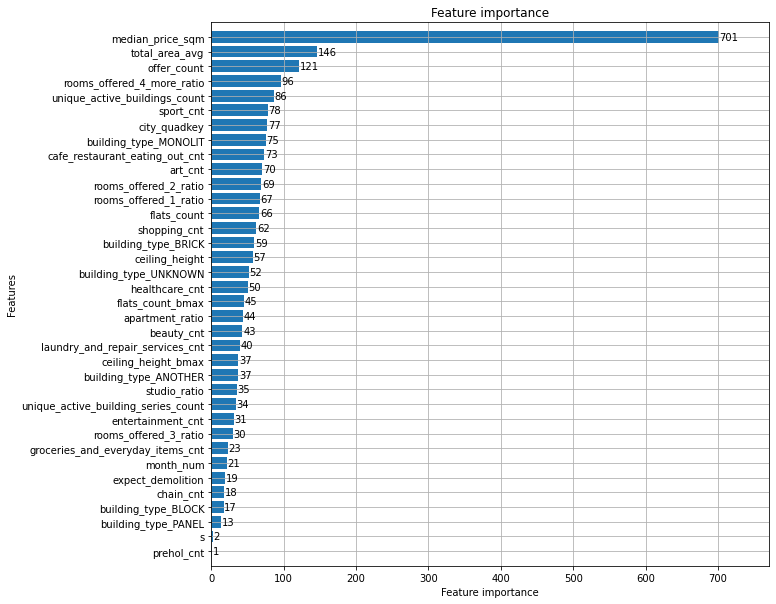

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(10, 10))
ax.set_xlabel('Значимость фактора')
ax.set_ylabel('Имя фактора')
ax.set_title('')
_ = lgb.plot_importance(model, height=0.8, ax=ax)

In [ ]:
calc_metrics(y_train, pred_train, y_test, pred_test, DESCRIBE + SPLIT_TIPE)

TRAIN:
R^2 :  0.995
MAE : 2803.093
RMSE: 7261.554
MAPE: 1.508

TEST:
R^2 :  0.993
MAE : 3532.873
RMSE: 8437.343
MAPE: 1.633


Выбор метрики: RMSE, также посмотрим дополнительно на MAPE

## Uplifts
Покажем динамику улучшения метрик по мере добавления источников. Считываем актуальный файл логов и выводим информацию в нужном разрезе.

In [ ]:
with open(PATH + 'model_logs.json', 'r') as fp:
    logs = json.load(fp)

In [ ]:
keys = ['Baseline_', 'Baseline_housebase_', 'Baseline_housebase_TimeFeat_', 
        'Baseline_housebase_TimeFeat_Lags_', 
        'Baseline_housebase_TimeFeat_Lags__TUNED',
        'AN_Baseline_housebase_TimeFeat_']
up_split_type = 'OOT'
up_train_test = 'TEST'
logs

{'AN_Baseline_housebase_TimeFeat_OOT': {'TEST': [0.652,
   11310.756,
   59894.016,
   1.988],
  'TRAIN': [0.996, 1944.264, 3357.127, 1.428]},
 'Baseline_OOS': {'TEST': [0.991, 3371.58, 9739.819, 1.563],
  'TRAIN': [0.993, 3206.056, 8571.37, 1.55]},
 'Baseline_OOT': {'TEST': [0.989, 3896.985, 10811.923, 1.662],
  'TRAIN': [0.992, 3138.233, 8651.772, 1.539]},
 'Baseline_housebase_OOS': {'TEST': [0.994, 3010.925, 7937.497, 1.538],
  'TRAIN': [0.995, 2897.819, 7148.052, 1.526]},
 'Baseline_housebase_OOT': {'TEST': [0.993, 3498.833, 8322.351, 1.63],
  'TRAIN': [0.995, 2793.405, 7243.526, 1.507]},
 'Baseline_housebase_TimeFeat_Lags_OOS': {'TEST': [0.995,
   2182.733,
   7180.118,
   1.346],
  'TRAIN': [0.997, 2062.636, 5741.502, 1.338]},
 'Baseline_housebase_TimeFeat_Lags_OOT': {'TEST': [0.99,
   2782.058,
   10161.256,
   1.462],
  'TRAIN': [0.996, 1958.315, 5938.24, 1.307]},
 'Baseline_housebase_TimeFeat_Lags__TUNEDOOS': {'TEST': [0.996,
   1992.256,
   6740.687,
   1.305],
  'TRAIN': [0.

По таблице получаем по out of time на тестовой выборке (порядок метрик такой же 
R^2: 1, 
MAE: 2,
RMSE: 3,
MAPE:4),
Baseline_	изначанльный датасет 
Baseline_housebase_	- добавляем датасет из истории объявлений

Baseline_housebase_TimeFeat_ добавлены фичи из временной метрики (месяц, квартал, праздники), метрика не улучшилась на out_of_time, но улучшилась на out_of_sample

Baseline_housebase_TimeFeat_Lags_	- метрика ухудшилась, но если смотреть на отложенной выборке, лаги сильно улучшают метрику

Baseline_housebase_TimeFeat_Lags__TUNED	- тюним модель и подбираем гиперпараметры, с помошью сетки grid search 

AN_Baseline_housebase_TimeFeat - с аномалиями

In [ ]:
df_dict = {}
for elem in keys:
    key = elem + up_split_type
    try:
        df_dict[elem] = logs[key][up_train_test]
    except Exception:
        pass

pd.DataFrame(df_dict)

,Baseline_,Baseline_housebase_,Baseline_housebase_TimeFeat_,Baseline_housebase_TimeFeat_Lags_,Baseline_housebase_TimeFeat_Lags__TUNED,AN_Baseline_housebase_TimeFeat_
0,0.989,0.993,0.993,0.990,0.986,0.652
1,3896.985,3498.833,3532.873,2782.058,3446.470,11310.756
2,10811.923,8322.351,8437.343,10161.256,12175.636,59894.016
3,1.662,1.630,1.633,1.462,1.632,1.988


В итоге на отложенной выборке финальная модель дала лучшее качество, но при этом если посмотреть на out_of_time можно увидеть, что после tune стало хуже, модель переобучилась.

## Test another models

### LinearRegression

In [ ]:
is_null = df_price.isna().sum()
drop_cols = is_null[is_null > 0].index.tolist()
fill_dict = df_price[drop_cols].mean()

In [ ]:
X_train_lin = X_train.fillna(fill_dict)
X_test_lin = X_test.fillna(fill_dict)

In [ ]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train_lin, y_train)

np.round(np.sqrt(mean_squared_error(y_test, model.predict(X_test_lin))), 3)

12564.323

### GradientBoostingRegressor

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

model = GradientBoostingRegressor()
model.fit(X_train_lin, y_train)

print(np.round(np.sqrt(mean_squared_error(y_test, model.predict(X_test_lin))), 3))
np.round(np.sqrt(mean_squared_error(y_train, model.predict(X_train_lin))), 3)

9323.833


8808.218

## Tune
Запускаем только для улучшения финальной итерации

In [ ]:
def find_best_params4lgb_regr_grid(
    X_train, 
    X_test, 
    y_train, 
    y_test,
    jobs_search = 5,
    verb_search = 1, 
    stopping_rounds = 50,
):
    get_zaic(X_train)
    param_grid = {
        # параметры ансамбля
        'n_estimators': [64, 100, 128],
        'learning_rate': [0.01, 0.1, 1],

        # параметры дерева
        'max_depth': [3, 5, 7],
        'reg_alpha': [1e-2, 0.1, 1],
        'reg_lambda': [1e-2, 0.1, 1]
    }
    cv = KFold(n_splits=4, shuffle=True)
    clf = lgb.LGBMRegressor(
        n_jobs=8, 
        objective='regression'
    )
    gs = GridSearchCV(
        clf,
        param_grid,
        scoring='neg_root_mean_squared_error', 
        cv=cv,
        verbose=verb_search, 
        n_jobs=jobs_search,
    )

    gs.fit(
        X_train, 
        y_train, 
        eval_metric='neg_root_mean_squared_error', 
        eval_set=[(X_train, y_train), (X_test, y_test)], 
        early_stopping_rounds=stopping_rounds
    )
    best_params = gs.best_estimator_.get_params()
    print('Best score (RMSE):', np.round(gs.best_score_, 3))
    
    return best_params

In [ ]:
best_params = find_best_params4lgb_regr_grid(X_train, X_test, y_train, y_test)

2022-05-21 10:59:25
72.55 Mb
(123491, 76)
Fitting 4 folds for each of 243 candidates, totalling 972 fits
[1]	training's l2: 8.08391e+09	valid_1's l2: 8.35227e+09
Training until validation scores don't improve for 50 rounds.
[2]	training's l2: 6.58072e+09	valid_1's l2: 6.77248e+09
[3]	training's l2: 5.36178e+09	valid_1's l2: 5.48648e+09
[4]	training's l2: 4.37209e+09	valid_1's l2: 4.45126e+09
[5]	training's l2: 3.56905e+09	valid_1's l2: 3.61114e+09
[6]	training's l2: 2.91775e+09	valid_1's l2: 2.93447e+09
[7]	training's l2: 2.38805e+09	valid_1's l2: 2.38325e+09
[8]	training's l2: 1.95858e+09	valid_1's l2: 1.93918e+09
[9]	training's l2: 1.60936e+09	valid_1's l2: 1.58262e+09
[10]	training's l2: 1.32506e+09	valid_1's l2: 1.29445e+09
[11]	training's l2: 1.09317e+09	valid_1's l2: 1.06005e+09
[12]	training's l2: 9.05099e+08	valid_1's l2: 8.72086e+08
[13]	training's l2: 7.51994e+08	valid_1's l2: 7.17909e+08
[14]	training's l2: 6.26958e+08	valid_1's l2: 5.94721e+08
[15]	training's l2: 5.25423e+0

In [ ]:
print(best_params)

model = lgb.LGBMRegressor(**best_params)
model.fit(X_train, y_train)
pred_test = model.predict(X_test)
pred_train = model.predict(X_train)

calc_metrics(y_train, pred_train, y_test, pred_test, DESCRIBE + '_TUNED' + 
             SPLIT_TIPE)

{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': 7, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 128, 'n_jobs': 8, 'num_leaves': 31, 'objective': 'regression', 'random_state': None, 'reg_alpha': 0.01, 'reg_lambda': 0.1, 'silent': True, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}
TRAIN:
R^2 :  0.996
MAE : 2556.198
RMSE: 6161.496
MAPE: 1.482

TEST:
R^2 :  0.993
MAE : 3424.838
RMSE: 8342.044
MAPE: 1.621
